In [252]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io, img_as_float, color

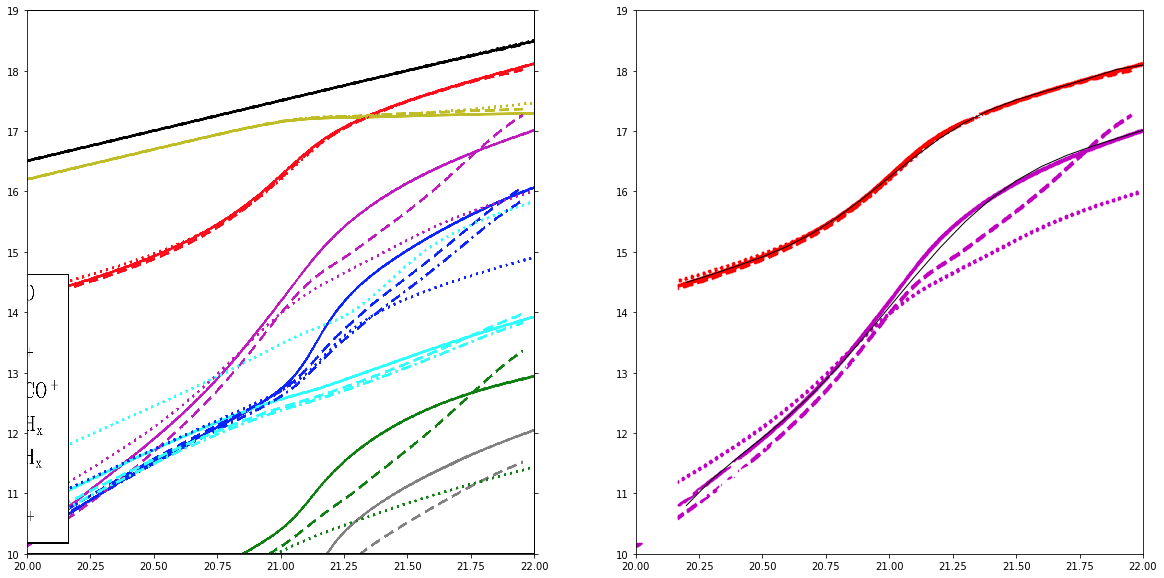

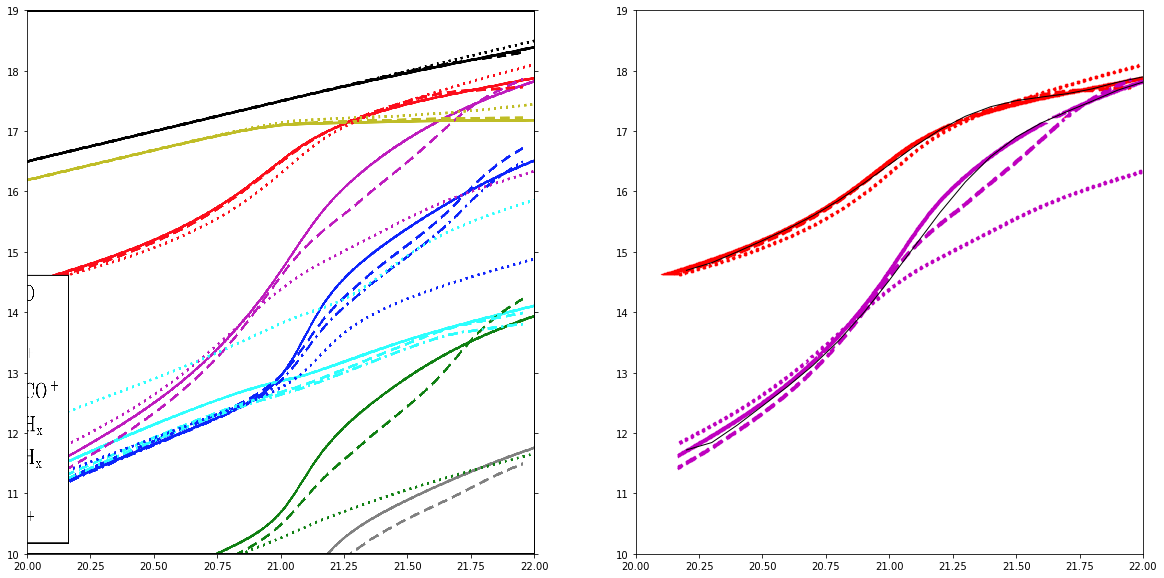

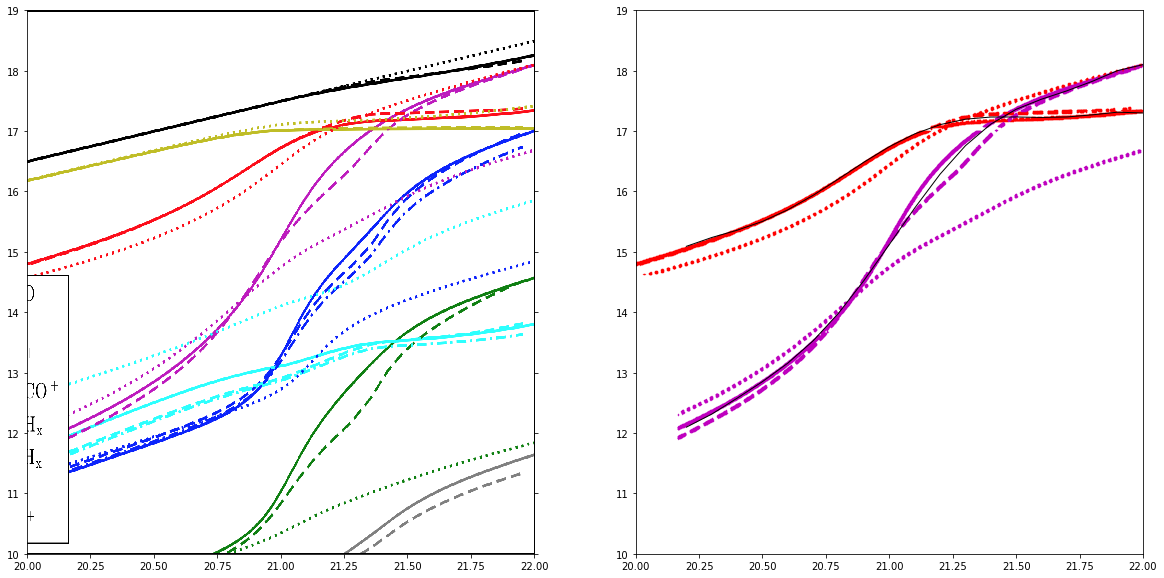

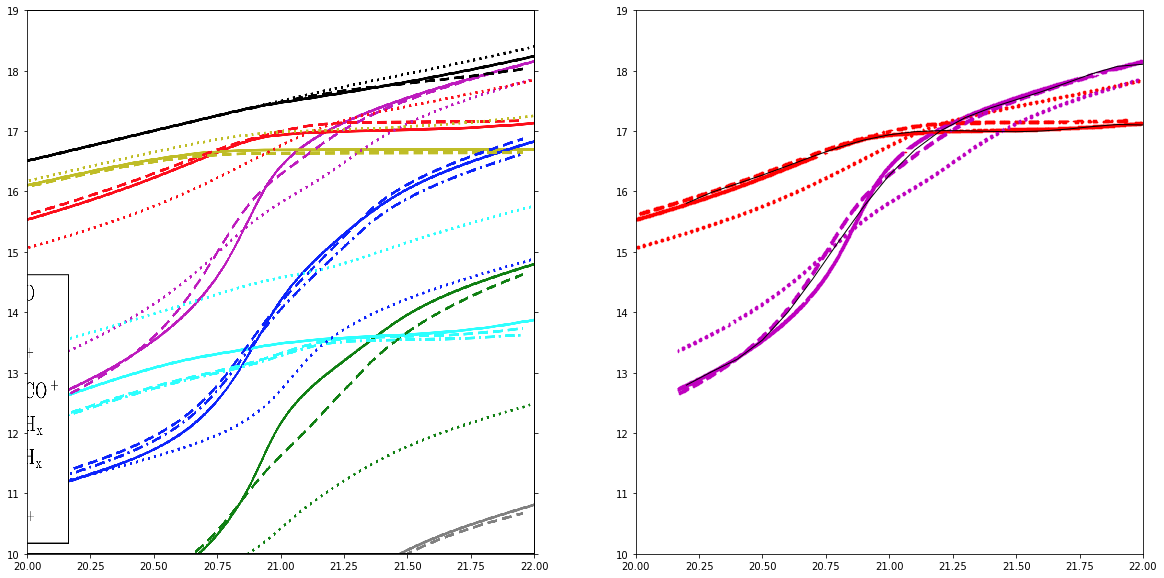

In [296]:

files=[50,100,200,1000]

# Colours of interest
cols = [('C',np.array([54.29,80.81,69.89]),'r'),
        ('CO',np.array([45.90,71.61,-46.57]),'m')]

results=[]
for fl in files:
    img=io.imread('/Users/codydirks/Desktop/{:}.png'.format(fl))

    img = img_as_float(img[:,:,0:3])

    # Put image into LAB colour space
    image_lab = color.rgb2lab(img)
    img = exposure.rescale_intensity(img)    
    # Loop through the color array and pick out the colored features
    # Compute distance between the color of interest and the actual image
    # http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.deltaE_cmc
    # "The usual values are kL=2, kC=1 for “acceptability”"
    num_x_pix=len(img[0])
    num_y_pix=len(img)
    
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_xlim(20,22)
    ax1.set_ylim(10,19)
    fit_results=[]
    for species,cie_col,rgb_col in cols:
        distance_color = color.deltaE_ciede2000(cie_col, image_lab, kL=2, kC=1, kH=0.5)    

        # Normalise distance
        distance_color = exposure.rescale_intensity(distance_color)

        # Mask image
        image_filtered = img.copy()
        image_filtered[distance_color > 0.1] = 1
        y,x=np.where(image_filtered[:,:,0] != 1)
        y=(-9./num_y_pix)*y+19.
        x=(2./num_x_pix)*x+20.

        # Plot it up
        ax0.imshow(img,aspect='auto',extent=[20,22,10,19])
        ax0.yaxis.set_ticks_position('both')
        #ax1.imshow(distance_color, cmap='gray')
        #ax1.imshow(image_filtered,aspect='auto',extent=[20,22,10,19])
        ax1.scatter(x,y,marker='o',color=rgb_col,s=.1)
        
        points=zip(x,y)
        fitx=np.empty(0)
        fity=np.empty(0)
        for val in np.arange(20.2,22,0.1):
            ys=[round(i[1],1) for i in points if round(i[0],1)==round(val,1)]
            mod=stats.mode(ys)[0][0]
            fitx=np.concatenate([fitx,[round(val,1)]])
            fity=np.concatenate([fity,[mod]])
            #ax1.plot(val,mod,'ko',markersize=10)
        cheb=np.polynomial.chebyshev.chebfit(fitx,fity,7)
        cheby=np.polynomial.chebyshev.chebval(fitx,cheb)
        fit_results.append((species,(fitx,cheby)))
        ax1.plot(fitx,cheby,'k-',linewidth=1)
    results.append((fl,fit_results))
        

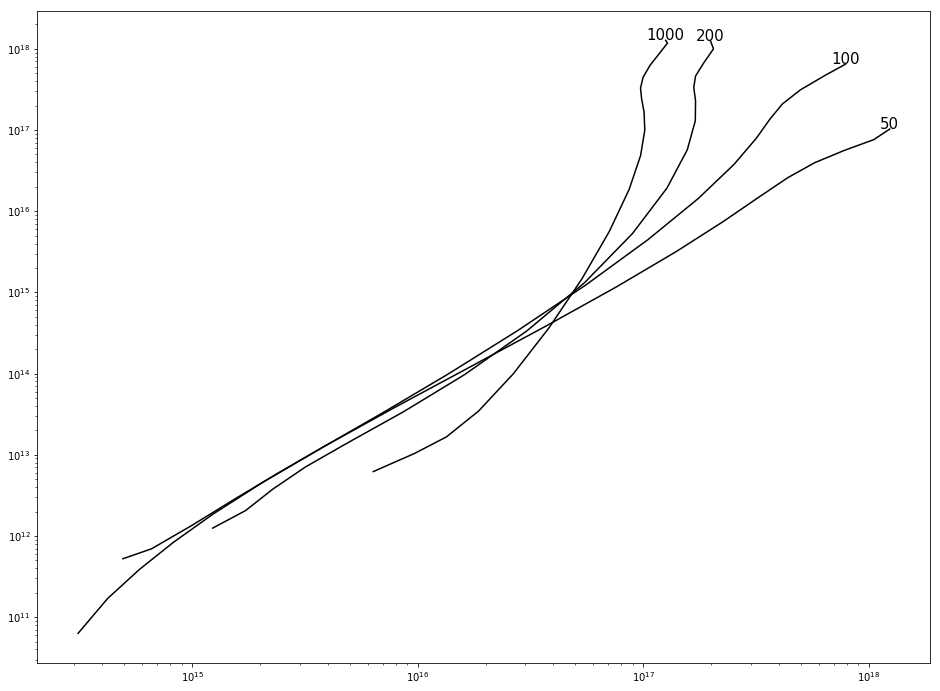

In [295]:
fig=plt.figure(figsize=(16,12))
subplt=plt.subplot(111)
for n,[(s1,(s1x,s1y)),(s2,(s2x,s2y))] in results:
    subplt.plot(10**s1y,10**s2y,'k-')
    subplt.text(10**s1y[-1],10**s2y[-1],str(n),fontsize=15,ha='center')
        
subplt.set_xscale('log')
subplt.set_yscale('log')